In [ ]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns

import scgen # install liek this: pip install git+https://github.com/LouiseDck/scgen
import dynchro

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
import torch
import random

# note that this does not make the result exactly reproducible

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Load and prepare data

In [4]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

# scGen, using lineage labels

In [ ]:
# setup: rename categories to ensure scgen doens't overfit on cluster labels

lin_cats = {
    "sB": "sB",
    "sBmid": "sBmid",
    "sC": "sC",
    "sC_batch": "sC",
    "sEndC": "sC",
    "sD": "sD",
    "sEndD": "sD",
}

d2_lin = d2.copy()
d1_lin = d1.copy()

d2_lin.obs["orig_milestones"] = d2_lin.obs.milestones
d1_lin.obs["orig_milestones"] = d1_lin.obs.milestones

d2_lin.obs["milestones"] = d2_lin.obs.milestones.map(lin_cats).astype("category")
d1_lin.obs["milestones"] = d1_lin.obs.milestones.map(lin_cats).astype("category")

dm_lin = {
    "control": d1_lin,
    "premature stop": d2_lin
}
dm_lin = ad.concat(dm_lin, label="batch")
dm_lin.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# perform batch effect correction with scGen

scgen.SCGEN.setup_anndata(dm_lin, batch_key="batch", labels_key="milestones")
model_lin = scgen.SCGEN(dm_lin)
model_lin.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)
corrected_adata_lin = model_lin.batch_removal()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

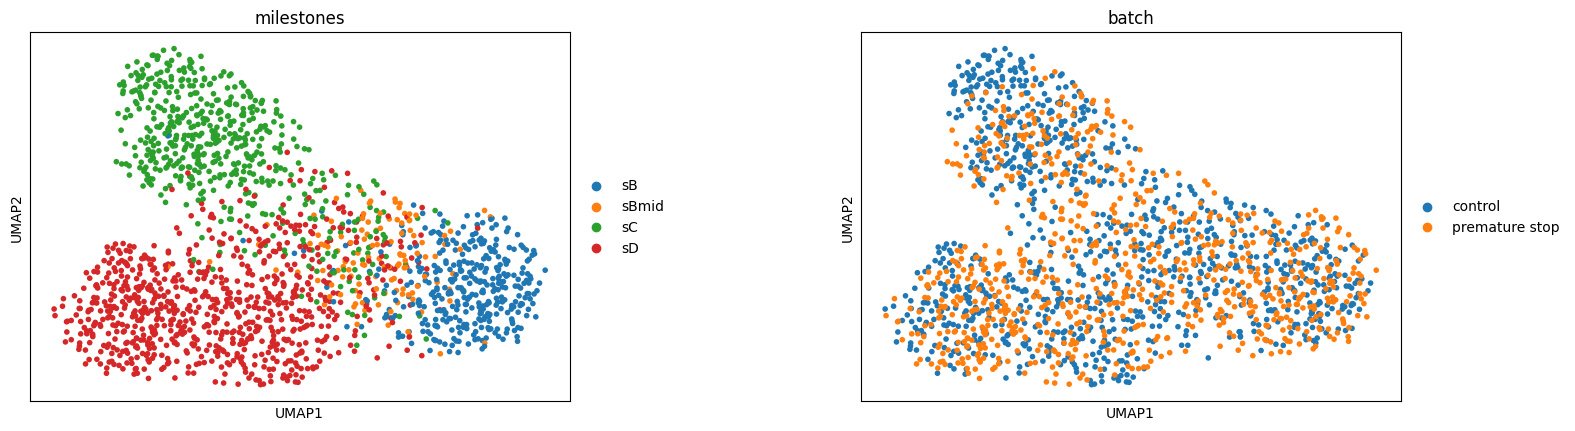

In [ ]:
sc.pp.neighbors(corrected_adata_lin, use_rep="corrected_latent")
sc.tl.umap(corrected_adata_lin)
sc.pl.umap(corrected_adata_lin, color=['milestones', 'batch'], wspace=0.4)

<Axes: xlabel='x', ylabel='y'>

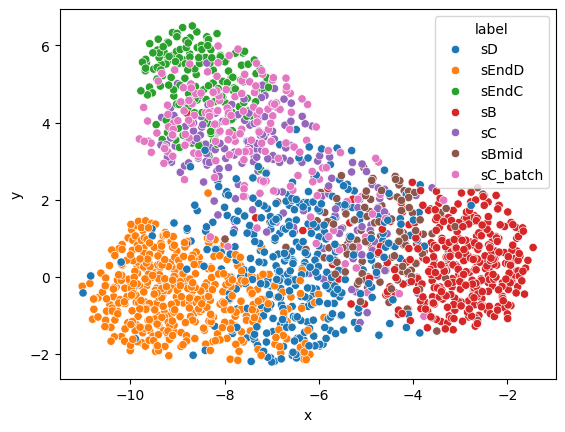

In [ ]:
# investigate the result

xvals = corrected_adata_lin.obsm["X_umap"][:, 0]
yvals = corrected_adata_lin.obsm["X_umap"][:, 1]
cats = np.concat((d1.obs["milestones"].values ,d2.obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

sns.scatterplot(
    data=legend_df,
    x="x",
    y="y",
    hue="label",
    legend=True,
)

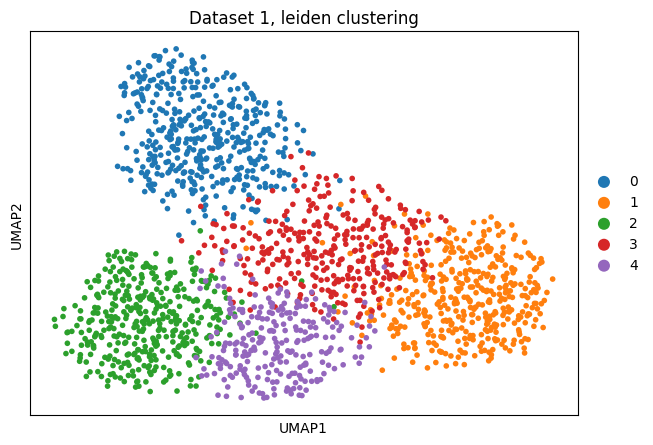

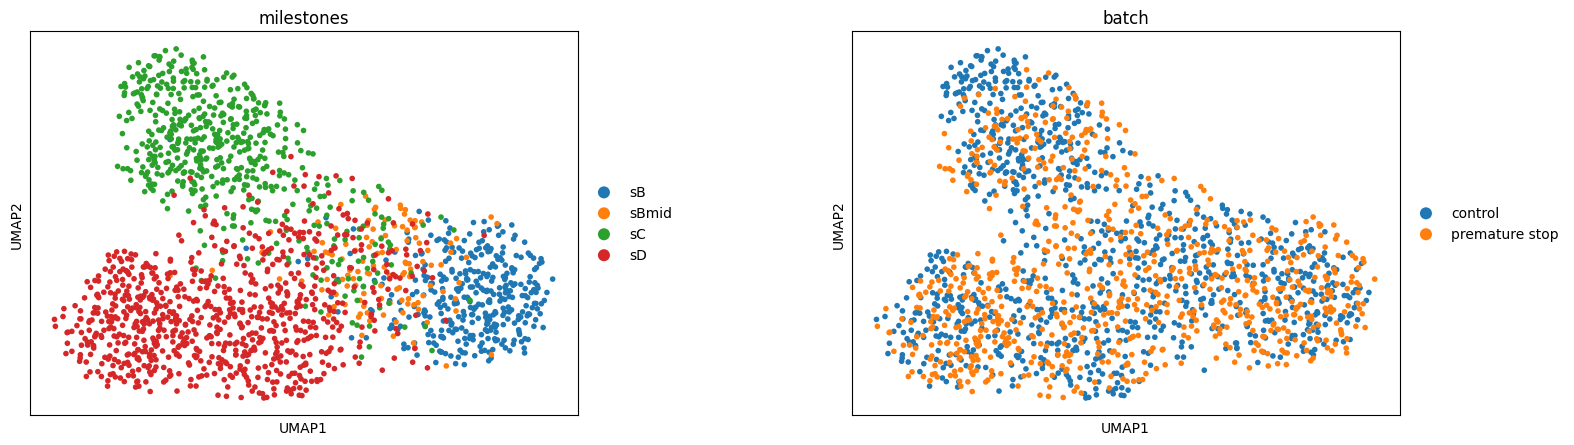

In [ ]:
sc.tl.leiden(corrected_adata_lin, resolution=1, key_added="leiden")
sc.pl.scatter(corrected_adata_lin, basis="umap", color='leiden1', title="Dataset 1, leiden clustering")
sc.pl.scatter(corrected_adata_lin, basis="umap", color=['milestones', 'batch'])

In [ ]:
corrected_adata_lin.uns["slingshot_start"] = ["1"]
corrected_adata_lin.uns["slingshot_end"] = ["0", "2"]

In [ ]:
corrected_adata_lin.write_h5ad("data/scgen2.h5ad")

Run slingshot in R:

Run part "scgen" in `slingshot.R` before continuing

## Pseudotime

In [6]:
scgen2_result = ad.read_h5ad("data/scgen2_slingshot.h5ad")
scgen2_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'orig_milestones', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'leiden1', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden', 'leiden1', 'leiden1_colors', 'milestones_colors', 'neighbors', 'slingshot_end', 'slingshot_start', 'umap'
    obsm: 'X_umap', 'corrected_latent', 'latent'
    layers: 'X'
    obsp: 'connectivities', 'distances'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


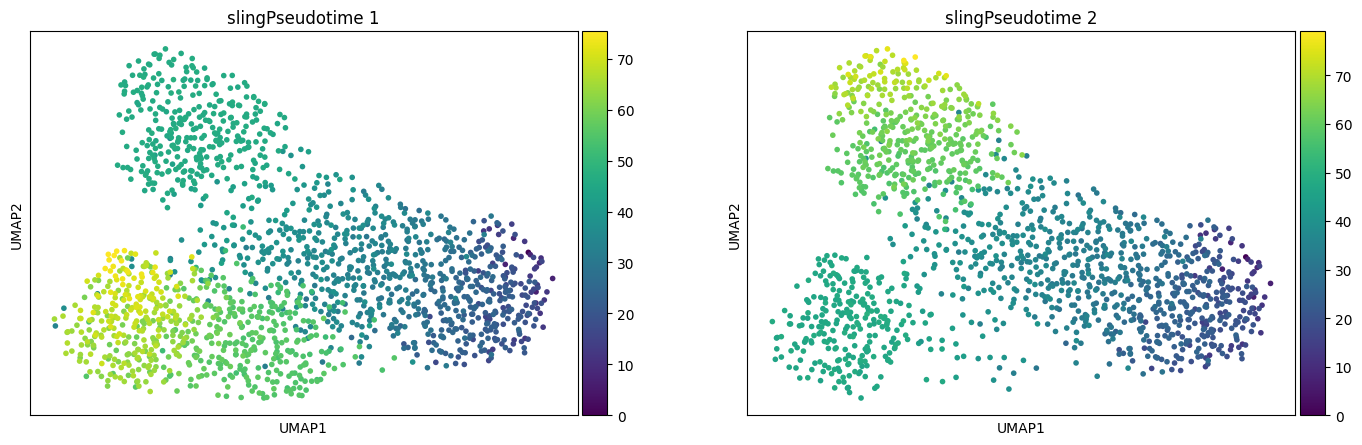

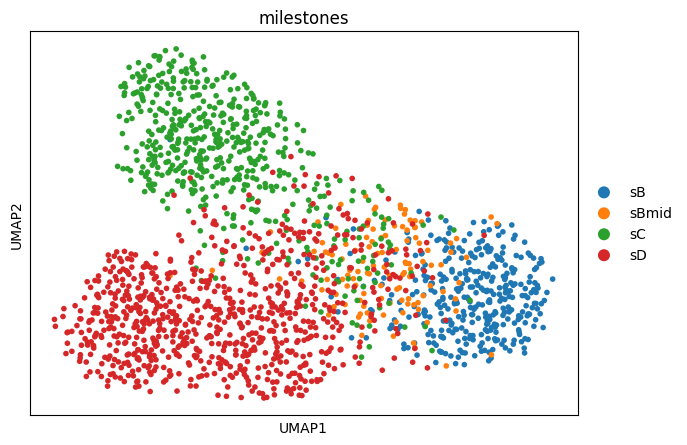

In [ ]:
scgen2_result.obsm["X_corrected_latent"] = scgen2_result.obsm["corrected_latent"]
sc.pl.scatter(scgen2_result, basis = "umap", color = ["slingPseudotime_1", "slingPseudotime_2"])
sc.pl.scatter(scgen2_result, basis="umap", color = ["milestones"])

In [10]:
clin = scgen2_result[~scgen2_result.obs["slingPseudotime_2"].isna()]
dlin = scgen2_result[~scgen2_result.obs["slingPseudotime_1"].isna()]

## Calculate kde densities

In [ ]:
clin_after = clin
dlin_after = dlin

# select all where linC is True
clin_orig = scgen2_result[scgen2_result.obs.linC == "TRUE"]
dlin_orig = scgen2_result[scgen2_result.obs.linD == "TRUE"]


In [ ]:
startC = min(clin_orig[clin_orig.obs["orig_milestones"] == "sC"].obs["orig_linC_pseudotime"])
startEndC = min(clin_orig[clin_orig.obs["orig_milestones"] == "sEndC"].obs["orig_linC_pseudotime"])
linmin = min(clin_orig.obs["orig_linC_pseudotime"])
linmax = max(clin_orig.obs["orig_linC_pseudotime"])

startC_normalized = (startC - linmin) / (linmax - linmin)
startEndC_normalized = (startEndC - linmin) / (linmax - linmin)

startC_normalized, startEndC_normalized

(0.18798988170404404, 0.5908188837727303)

In [ ]:
bw = 0.1
pseudotimes =["orig_linC_pseudotime", "slingPseudotime_2"]
method = "scgen"

d1_b_linC = clin_orig[clin_orig.obs["batch"] == "control"]
d2_b_linC = clin_orig[clin_orig.obs["batch"] == "premature stop"]

d1_a_linC = clin_after[clin_after.obs["batch"] == "control"]
d2_a_linC = clin_after[clin_after.obs["batch"] == "premature stop"]

res1_orig = dynchro.tl.get_kde_eval(d1_b_linC, pseudotimes[0], mode = "only_results", bandwidth = bw)
res1_after = dynchro.tl.get_kde_eval(d1_a_linC, pseudotimes[1], mode = "only_results", bandwidth = bw)

res2_orig = dynchro.tl.get_kde_eval(d2_b_linC, pseudotimes[0], mode = "only_results", bandwidth = bw)
res2_after = dynchro.tl.get_kde_eval(d2_a_linC, pseudotimes[1], mode = "only_results", bandwidth = bw)

both_orig = dynchro.tl.get_kde_eval(clin_orig, pseudotimes[0], mode = "only_results", bandwidth = bw)
both_after = dynchro.tl.get_kde_eval(clin_after, pseudotimes[1], mode = "only_results", bandwidth = bw)

dump = {
    "d1": {
        "orig": res1_orig,
        "after": res1_after,
        "cutoff": startEndC_normalized,
    },
    "d2": {
        "orig": res2_orig,
        "after": res2_after,
        "cutoff": startEndC_normalized,
    },
    "both": {
        "orig": both_orig,
        "after": both_after,
        "cutoff": startEndC_normalized,
    }
}
import pickle
pickle.dump(dump, open(f"data/{method}_dump.p", "wb"))

/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector orig_linC_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_linC_pseudotime'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dataset.obs[f"norm_{pseudotime_key}"] = vector
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:19: UserWarning: Vector slingPseudotime_2 is not normalized between 0 and 1. Normalizing it now and storing as 'norm_slingPseudotime_2'.
  warn(f"Vector {pseudotime_key} is not normalized between 0 and 1. Normalizing it now and storing as 'norm_{pseudotime_key}'.")
/home/louise/Work/dynchro/src/dynchro/tl/metrics.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act